In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import os
from sklearn.metrics import accuracy_score

print("Current path:", os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

plt.style.use('./notebooks/tutorial_style.txt')


Current path: /home/ubuntu/BrainDecoding/notebooks


In [2]:
directories = ["outputs/MT1/MT_1/subj_2_20250507_1031", "outputs/MT1/MT_1/subj_4_20250507_1051", "outputs/MT1/MT_1/subj_5_20250507_1111", "outputs/MT1/MT_1/subj_6_20250507_1132", "outputs/MT1/MT_1/subj_7_20250507_1153", "outputs/MT1/MT_1/subj_10_20250507_1213", "outputs/MT1/MT_1/subj_11_20250507_1234"]

desc = ["subj_2", "subj_4", "subj_5", "subj_6", "subj_7", "subj_10", "subj_11"]

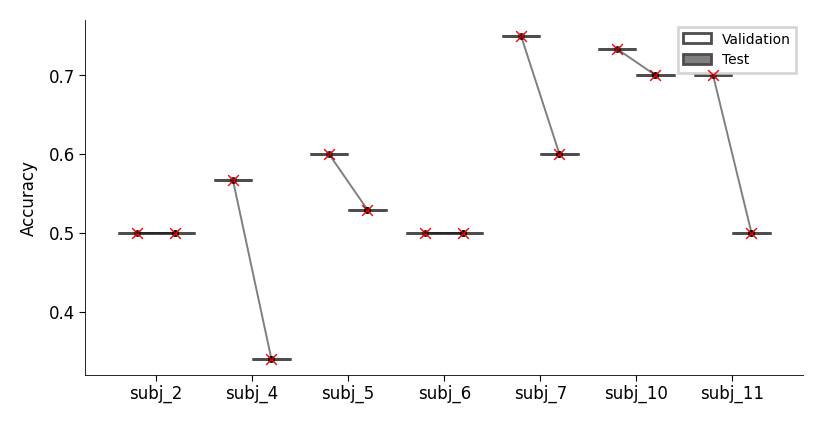

In [3]:
plot_data = []

for idx, dir in enumerate(directories):
    val_raw = torch.load(os.path.join(dir, "val_outputs.pt"))
    test_raw = torch.load(os.path.join(dir, "test_outputs.pt"))

    val_outputs, val_labels, val_subjects = val_raw["outputs"], val_raw["labels"], val_raw["subjects"]
    test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]

    for subject in torch.unique(val_subjects):
        val_mask = val_subjects == subject
        val_acc = accuracy_score(val_labels[val_mask], torch.argmax(val_outputs[val_mask], dim=1))

        test_mask = test_subjects == subject
        if test_mask.sum() > 0:
            test_acc = accuracy_score(test_labels[test_mask], torch.argmax(test_outputs[test_mask], dim=1))

            plot_data.append({
                "Run": idx,
                "Subject": int(subject),
                "Accuracy": val_acc,
                "Set": "Validation"
            })
            plot_data.append({
                "Run": idx,
                "Subject": int(subject),
                "Accuracy": test_acc,
                "Set": "Test"
            })

df = pd.DataFrame(plot_data)

# Plot
fig, ax = plt.subplots(figsize=(4, 2), dpi=200)

sns.boxplot(x="Run", y="Accuracy", hue="Set", data=df, palette=["white", "gray"], showfliers=False, ax=ax)
sns.stripplot(x="Run", y="Accuracy", hue="Set", data=df, palette='dark:k', dodge=True, ax=ax, alpha=1, legend=False, jitter=0.03)

# Connect matching subjects with a line
hue_offsets = {"Validation": -0.2, "Test": 0.2} 

for run in df["Run"].unique():
    run_df = df[df["Run"] == run]
    subjects = run_df["Subject"].unique()
    for subject in subjects:
        sub_df = run_df[run_df["Subject"] == subject]
        if len(sub_df) == 2:
            val_row = sub_df[sub_df["Set"] == "Validation"].iloc[0]
            test_row = sub_df[sub_df["Set"] == "Test"].iloc[0]
            x1 = run + hue_offsets["Validation"]
            x2 = run + hue_offsets["Test"]
            y1 = val_row["Accuracy"]
            y2 = test_row["Accuracy"]
            ax.plot([x1, x2], [y1, y2], color="black", alpha=0.5, linewidth=0.7, zorder=10000)

means = df.groupby(["Run", "Set"])["Accuracy"].mean().reset_index()

for _, row in means.iterrows():
    x = row["Run"] + hue_offsets[row["Set"]]
    y = row["Accuracy"]
    ax.scatter(x, y, marker="x", color="red", s=15, zorder=1000, label='_none_') 

ax.set_ylabel("Accuracy")
ax.set_xlabel("")
ax.set_xticks(range(len(directories)), desc)
ax.legend(title=False)
plt.show()

In [4]:
directories = ["outputs/ET/backbone_20250428", "outputs/ET/backbonesjlayer_20250428", "outputs/ET/backbonesjlayeratt_20250428", "outputs/ET/backbonesjlayeratttrans_resample_20250429"]

desc = ["Backbone", "+ Subject Layer", "+ Attention", "+ Augmentation"]

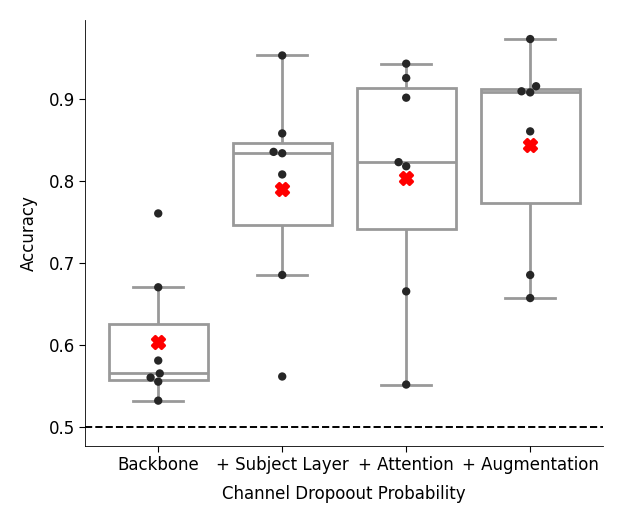

In [5]:
plot_data = []

for idx, dir in enumerate(directories):
    test_raw = torch.load(os.path.join(dir, "test_outputs.pt"))
    test_outputs, test_labels, test_subjects = test_raw["outputs"], test_raw["labels"], test_raw["subjects"]

    for subject in torch.unique(test_subjects):

        test_mask = test_subjects == subject
        if test_mask.sum() > 0:
            test_acc = accuracy_score(test_labels[test_mask], torch.argmax(test_outputs[test_mask], dim=1))

            plot_data.append({
                "Run": idx,
                "Subject": int(subject),
                "Accuracy": test_acc,
                "Set": "Test"
            })

df = pd.DataFrame(plot_data)

# Plot
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=200)

sns.boxplot(x="Run", y="Accuracy", hue="Set", data=df, showfliers=False, ax=ax, palette=["white"])
sns.swarmplot(x="Run", y="Accuracy", hue="Set", data=df, palette='dark:k', ax=ax, alpha=1, legend=False, marker='o', s=3)

ax.axhline(y=0.5, color="black", linestyle="--", linewidth=0.7, zorder=10000)


means = df.groupby(["Run", "Set"])["Accuracy"].mean().reset_index()

for _, row in means.iterrows():
    x = row["Run"]
    y = row["Accuracy"]
    ax.scatter(x, y, marker="X", color="red", s=20, zorder=1000, label='_none_') 

ax.set_ylabel("Accuracy")
ax.set_xlabel("Channel Dropoout Probability")
ax.set_xticks(range(len(directories)), desc)
legend = ax.legend(title=False)
legend.set_visible(False)
plt.show()